# Part 1: Attention Model

## Step 1: Import Libraries

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from datetime import date
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Flatten

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Print versions
!python --version
!pip3 list | findstr scikit
!pip3 list | findstr tensorflow
!pip3 list | findstr matplotlib

print("pandas Version:", pd.__version__)
print("NumPy Version:", np.__version__)
print("Seaborn Version:", sns.__version__)

Python 3.12.5
scikit-learn            1.5.2
tensorflow              2.18.0
tensorflow_intel        2.18.0
matplotlib              3.9.2
matplotlib-inline       0.1.7
pandas Version: 2.2.3
NumPy Version: 1.26.4
Seaborn Version: 0.13.2


## Step 2: Create Helper Functions

In [3]:
#Calculate Days Since Start of Year
def days_since_start(year):
    today = date.today()
    start = date(year, 1, 1)
    difference = today - start
    return difference.days

In [4]:
#Convert Data to Supervised Format
def to_supervised_attention(data, steps=1):
    X, y = [], []
    for i in range(len(data) - steps - 1):
        X.append(data[i:(i + steps), 0])
        y.append(data[i + steps, 0])
    return np.array(X), np.array(y)

In [5]:
#Build Attention Model
def build_attention_model(shape):
    # Input layer
    inp = Input(shape=shape)
    
    # LSTM layer
    lstm = LSTM(64, return_sequences=True)(inp)
    
    # Attention layer
    attn = Attention()([lstm, lstm])
    flat = Flatten()(attn)
    
    # Output layer
    out = Dense(1)(flat)
    
    # Compile the model
    model = Model(inp, out)
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

## Step 3: Prepare and Process the data

In [6]:
#Generate Synthetic Data
# Set seed for reproducibility
np.random.seed(42)

# Calculate days since the start of 2024
days_attention = days_since_start(2024)

# Generate a date range
dates_attention = pd.date_range(start='2024-01-01', periods=days_attention, freq='D')

# Generate synthetic cumulative random walk data
values_attention = np.random.randn(days_attention).cumsum()

In [7]:
# Create a DataFrame
df_attention = pd.DataFrame(values_attention, index=dates_attention, columns=['Value'])

# Display the first few rows
print(df_attention.head())

               Value
2024-01-01  0.496714
2024-01-02  0.358450
2024-01-03  1.006138
2024-01-04  2.529168
2024-01-05  2.295015


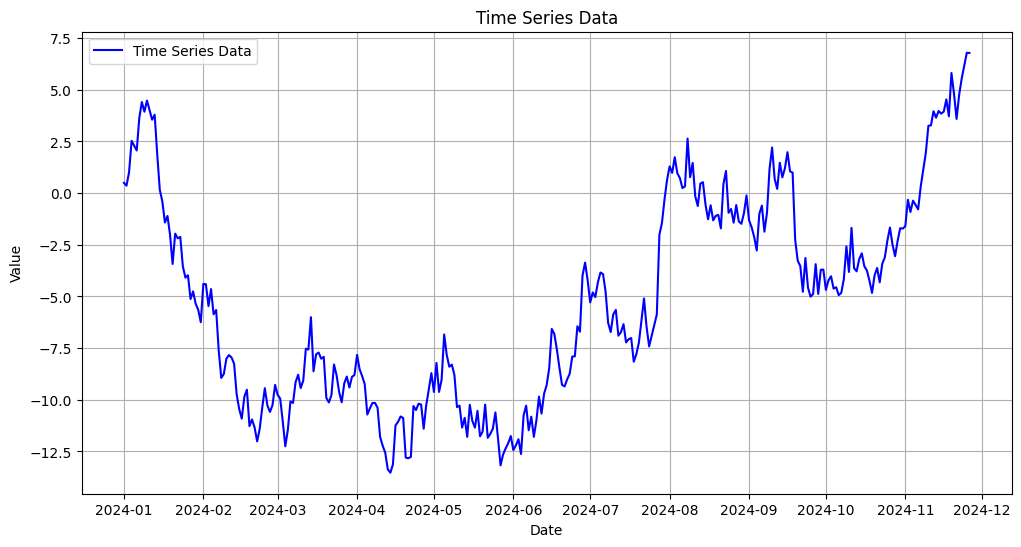

In [8]:
#Visualize the Data
plt.figure(figsize=(12, 6))
plt.plot(df_attention.index, df_attention['Value'], label='Time Series Data', color='blue')
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
#Normalize the data
# Normalize data to the range [0, 1]
scaler_attention = MinMaxScaler(feature_range=(0, 1))
scaled_attention = scaler_attention.fit_transform(df_attention)

In [10]:
#Convert data to supervised learning format
# Set time steps
steps_attention = 10

# Convert data to supervised format
X_attention, y_attention = to_supervised_attention(scaled_attention, steps_attention)

# Reshape X for LSTM: [samples, time steps, features]
X_attention = X_attention.reshape((X_attention.shape[0], X_attention.shape[1], 1))

# Print shapes
print("Shape of X:", X_attention.shape)
print("Shape of y:", y_attention.shape)

Shape of X: (320, 10, 1)
Shape of y: (320,)


## Step 4: Create, Fit, Predict, and Visualize the Attention Model

In [11]:
#Build the Model
# Create the model
model_attention = build_attention_model((steps_attention, 1))

# Print the model summary
model_attention.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 10, 64)    │     16,896 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 10, 64)    │          0 │ lstm[0][0],       │
│ (Attention)         │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 640)       │          0 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │        641 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,537 (68.50 KB)

 Trainable params: 17,537 (68.50 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train the Model
model_attention.fit(X_attention, y_attention, epochs=50, batch_size=32, verbose=0)

In [13]:
#Make Predictions
attention_preds = model_attention.predict(X_attention)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


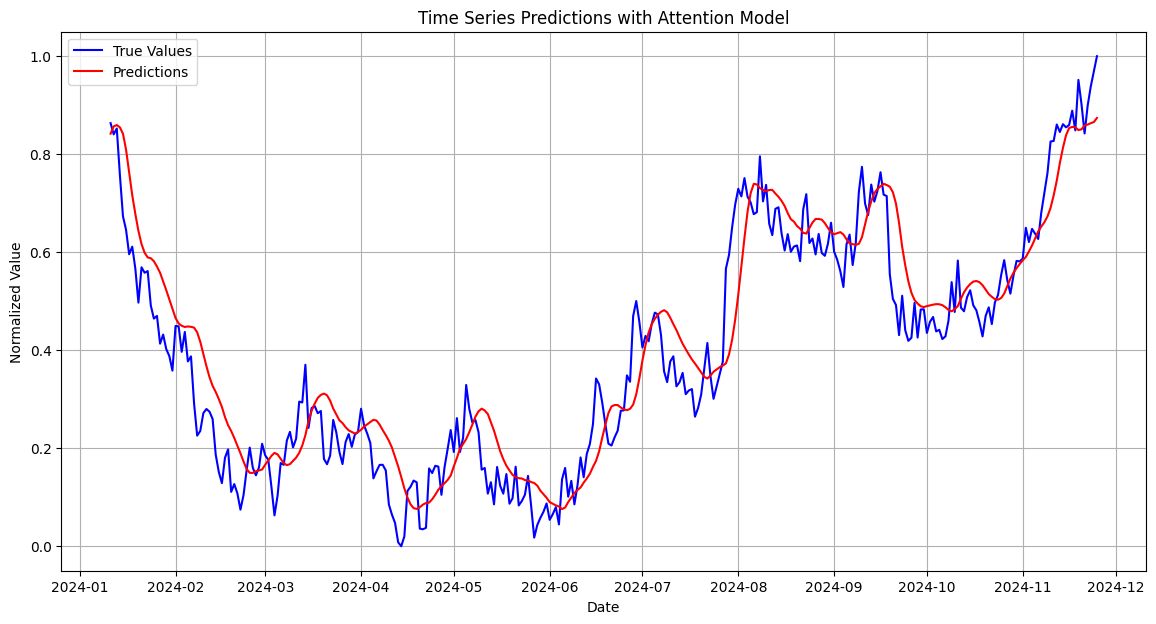

In [14]:
#Prepare Data for plotting
pred_idx = df_attention.index[steps_attention:len(attention_preds) + steps_attention]
true_idx = df_attention.index[steps_attention:len(y_attention) + steps_attention]

#Plot predictions vs true values
plt.figure(figsize=(14, 7))
plt.plot(true_idx, y_attention, label='True Values', color='blue')
plt.plot(pred_idx, attention_preds.flatten(), label='Predictions', color='red') 
plt.title('Time Series Predictions with Attention Model')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True)
plt.show()

# Part 2: Transformer Model

## Step 1: Import Libraries and print versions

In [15]:
# Libraries Used
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from datetime import date, datetime
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LayerNormalization, MultiHeadAttention, Dropout, Embedding, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [16]:
# Display Python and library versions
!python --version
!pip3 list | findstr scikit
!pip3 list | findstr matplotlib
!pip3 list | findstr tensorflow

print("Pandas Version:", pd.__version__)
print("NumPy Version:", np.__version__)

Python 3.12.5
scikit-learn            1.5.2
matplotlib              3.9.2
matplotlib-inline       0.1.7
tensorflow              2.18.0
tensorflow_intel        2.18.0
Pandas Version: 2.2.3
NumPy Version: 1.26.4


## Step 2: Create Helper Functions

In [17]:
#Get Date Difference from start of year to today
def days_from_year_start(dtYear):
    today = date.today()
    year_start = date(dtYear, 1, 1)
    difference = (today - year_start)
    return difference.days


In [18]:
#Convert data to supervised learning format
def create_supervised_data(data_array, sequence_length):
    # Initialize an empty list to store the sequences
    sequences_list = []
    
    # Iterate over the data to extract sequences
    for index in range(len(data_array) - sequence_length):
        sequences_list.append(data_array[index:index + sequence_length])
    
    # Convert the list of sequences to a numpy array
    return np.array(sequences_list)

In [20]:
class TransformerForecaster(tf.keras.Model):
    def __init__(self, num_heads, model_dim, num_blocks, output_dim):
        super(TransformerForecaster, self).__init__()
        
        # Multi-head attention layers
        self.attention_blocks = [
            layers.MultiHeadAttention(num_heads=num_heads, key_dim=model_dim) 
            for _ in range(num_blocks)
        ]
        
        # Dense layers
        self.feedforward_blocks = [
            layers.Dense(model_dim, activation='relu') 
            for _ in range(num_blocks)
        ]
        
        # Final fully connected output layer
        self.output_layer = layers.Dense(output_dim)

    def call(self, inputs):
        # Expand input dimensions
        x = tf.expand_dims(inputs, axis=2)
        
        # Process input through each attention and feed-forward block
        for attention_layer, dense_layer in zip(self.attention_blocks, self.feedforward_blocks):
            # Apply multi-head attention
            attention_output = attention_layer(x, x)
            
            # Apply feed-forward dense layer and residual connection
            x = dense_layer(attention_output) + x
        
        # Use the last time step's representation for prediction
        return self.output_layer(x[:, -1, :])

## Step 3: Prepare and Process Data

In [21]:
# Set seed for reproducibility
np.random.seed(42)

# Get the period of date generation
Period = days_from_year_start(2024)

#Generate a date range
date_range = pd.date_range(start = '2024-01-01', periods = Period, freq = 'D')

# Generate random data
random_data = np.random.randn(Period).cumsum()

Data_frame = pd.DataFrame(random_data, columns=['Value'])
Data_frame['Date'] = date_range
Data_frame.set_index('Date', inplace = True)

#Print data frame head
print(Data_frame.head())

               Value
Date                
2024-01-01  0.496714
2024-01-02  0.358450
2024-01-03  1.006138
2024-01-04  2.529168
2024-01-05  2.295015


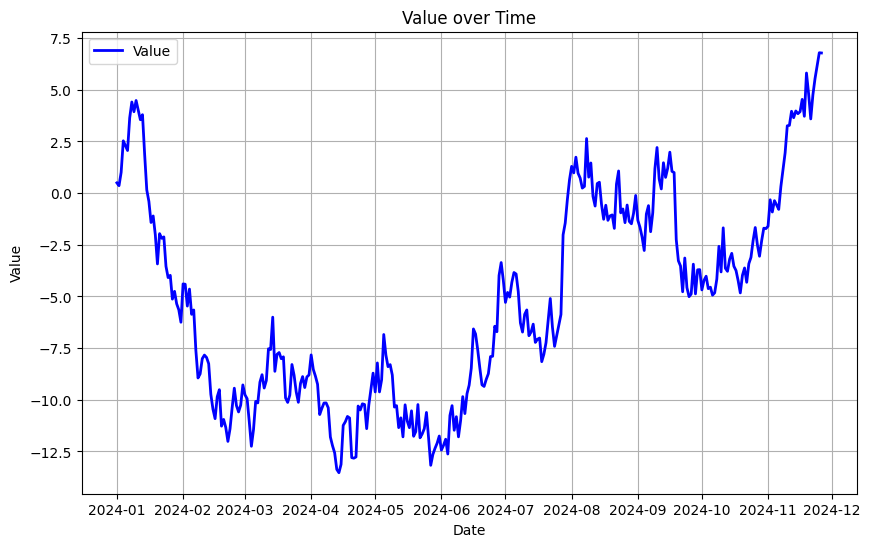

In [22]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(Data_frame.index, Data_frame['Value'], label='Value', color='blue', linewidth=2)

# Add title and labels
plt.title('Value over Time')
plt.xlabel('Date')
plt.ylabel('Value')

# Add a grid
plt.grid(True)

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [23]:
#Normalize the data
scaler = MinMaxScaler()
Data_frame['Normalized_Value'] = scaler.fit_transform(Data_frame[['Value']])

In [24]:
#Convert data to supervised learning format
sequence_length = 30
sequences_list = create_supervised_data(Data_frame['Normalized_Value'].values, sequence_length)
X = sequences_list[:, :-1]
y = sequences_list[:, -1]

## Step 4: Create, Fit, Predict, and Visualize the Transformer Model

In [25]:
#Declare the hyper parameters
num_heads = 4
model_dim = 64
num_blocks = 2
output_dim = 1

n_epochs = 50
batch_size = 32
learning_rate = 0.001

In [26]:
#Create the model
Transformer_Model = TransformerForecaster(num_heads = num_heads, model_dim = model_dim, num_blocks = num_blocks, output_dim = output_dim)
Transformer_Model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate), loss = 'mse')
print(Transformer_Model.summary())


Model: "transformer_forecaster"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ multi_head_attention            │ ?                      │   0 (unbuilt) │
│ (MultiHeadAttention)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_attention_1          │ ?                      │   0 (unbuilt) │
│ (MultiHeadAttention)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [27]:
#Train the model
EarlyStop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)
History = Transformer_Model.fit(X, y, epochs=n_epochs, batch_size=batch_size, validation_split = 0.2, callbacks=[EarlyStop], verbose=0)

In [28]:
#Make Predictions
yPred = Transformer_Model.predict(X)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


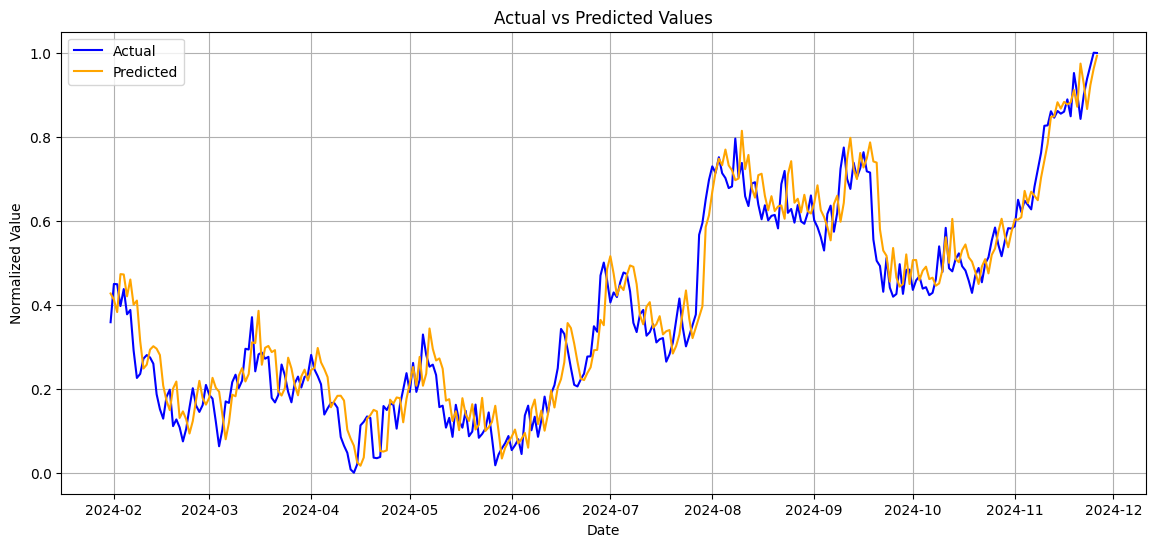

In [29]:
# Plot actual vs predicted values
plt.figure(figsize=(14, 6))
plt.plot(Data_frame.index[sequence_length:], Data_frame['Normalized_Value'][sequence_length:], label='Actual', color='blue')
plt.plot(Data_frame.index[sequence_length:], yPred, label='Predicted', color='orange')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True)
plt.show()